In [ ]:
import numpy as np
import pandas as pd
import os
from pathlib import Path

from numpy import arange
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

print(os.path.abspath("."))

# Specify Country:
country = ['Algeria','Angola','Benin','Botswana','Burkina Faso','Burundi','Cameroon','Chad','Comoros','Djibouti','Eritrea',
           'Ethiopia','Gabon','Ghana','Guinea','Kenya','Lesotho','Madagascar','Malawi','Mali','Mauritania','Morocco',
           'Mozambique','Namibia','Niger','Nigeria','Rwanda','Senegal','Sierra Leone','Somalia','Togo','Tunisia','Uganda',
           'Zambia','Zimbabwe']

#### Load & Preprocessing:

In [26]:
def get_yield_data() -> pd.DataFrame:
    yieldPath = Path(str(Path(os.getcwd()).parent.absolute()) + '/Group Project/Data/Yields/all_country_crop_yield_tons_per_hectare.csv')
    df = pd.read_csv(yieldPath)
    #df = df[df['Country Name'].isin(country)]
    df = df.melt(id_vars=["Country Name"], # narrow format 
                var_name="Year",   # rename
              value_name="Yield")  # rename
    df['Year'] = df['Year'].astype(int)
    return df

dfYieldLabel = get_yield_data()
#dfYieldLabel

# Expand this to include combine function below....
def get_VI_data() -> pd.DataFrame:
    trainPath = Path(str(Path(os.getcwd()).parent.absolute()) + '/Group Project/Data/NDVI/Country_EVI_NDVI.csv')
    df = pd.read_csv(trainPath)
    #df = df[df['Country Name'].isin(country)]
    df['Year'] = pd.DatetimeIndex(df['Date']).year.astype(int)
    df = df.groupby(['Country Name', 'Year'], as_index=False).mean() # avg by year
    return df

dfTrainData = get_VI_data()
#dfTrainData

In [28]:
#### Yield Data:

def get_yield_data() -> pd.DataFrame:
    yieldPath = Path(str(Path(os.getcwd()).parent.absolute()) + '/Group Project/Data/Yields/all_country_crop_yield_tons_per_hectare.csv')
    df = pd.read_csv(yieldPath)
    #df = df[df['Country Name'].isin(country)]
    df = df.melt(id_vars=["Country Name"], # narrow format 
                var_name="Year",   # rename
              value_name="Yield")  # rename
    df['Year'] = df['Year'].astype(int)
    return df

dfYieldLabel = get_yield_data()
#dfYieldLabel

In [8]:
#### NDVI & EVI Data:

def get_VI_data() -> pd.DataFrame:
    trainPath = Path(str(Path(os.getcwd()).parent.absolute()) + '/Group Project/Data/NDVI/Country_EVI_NDVI.csv')
    df = pd.read_csv(trainPath)
    #df = df[df['Country Name'].isin(country)]
    df['Year'] = pd.DatetimeIndex(df['Date']).year.astype(int)
    df = df.groupby(['Country Name', 'Year'], as_index=False).mean() # avg by year
    return df

dfTrainData = get_VI_data()
#dfTrainData

In [10]:
#### Test, Train Split:

predictYears = [2018] #[2019, 2020, 2021]

def combine_train_test() -> pd.DataFrame:
    df = pd.merge(dfTrainData, dfYieldLabel,  how='left', left_on=['Country Name','Year'], right_on = ['Country Name','Year'])
    df = df[df['Country Name'].isin(country)]
    #df = df[(df['Country Name'] == predictCountry)] # All Countries
    return df

yearly_df = combine_train_test()
yearly_df.shape

(770, 5)

In [12]:
yearly_df = yearly_df.drop(yearly_df.index[yearly_df.Year.isin([predictYears])])
trainData = yearly_df.drop('Country Name', 1).dropna().values

X, y = trainData[:, :-1], trainData[:, -1]
#trainData

predData = yearly_df[yearly_df.Year.isin(predictYears)].drop(['Country Name', 'Yield'], 1).to_numpy()
y_test = yearly_df[yearly_df.Year.isin(predictYears)].drop(['Country Name', 'Year', 'NDVI', 'EVI'], 1).to_numpy()
#y_test

#### Ridge Regression:

In [14]:
alphas = 10**np.linspace(10,-2,100)*0.5
#alphas

ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 3)

Text(0, 0.5, 'weights')

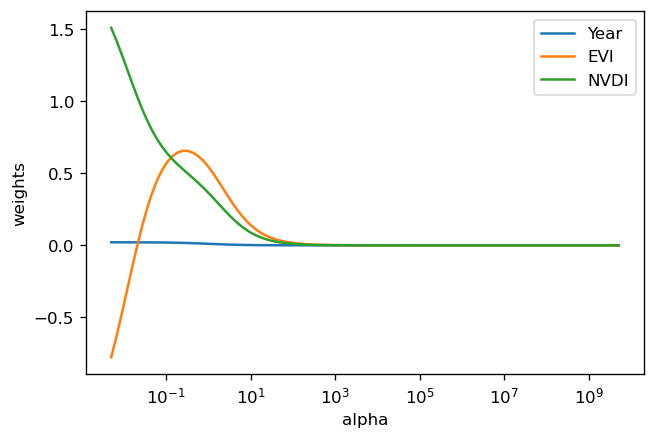

In [15]:
plt.figure(figsize=(6,4), dpi=120)
ax = plt.gca()
#plt.title(predictCountry)
ax.plot(alphas, coefs)
ax.legend(['Year', 'EVI','NVDI'])
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [16]:
#### Find optimal alpha from CV, grid search alpha grid
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_absolute_percentage_error', normalize = True)
ridgecv.fit(X, y)
ridgecv.alpha_

266.8349615603151

In [17]:
ridgeFinal = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridgeFinal.fit(X, y)

ridgeFinal

Ridge(alpha=266.8349615603151, normalize=True)

In [22]:
### make a prediction
yhat = ridgeFinal.predict(predData)
yhat

array([1.27382568, 1.27699114, 1.27675203, 1.27532127, 1.27558305,
       1.27710946, 1.27739197, 1.2745489 , 1.2779386 , 1.27355445,
       1.27409319, 1.27586787, 1.27699022, 1.27691171, 1.27721177,
       1.27577213, 1.27546973, 1.27654586, 1.27621545, 1.27438859,
       1.27376999, 1.27450132, 1.27711948, 1.27457711, 1.27392694,
       1.27625368, 1.27708152, 1.27559084, 1.27779395, 1.27474397,
       1.2769534 , 1.27438495, 1.27693847, 1.27690096, 1.27625583])

In [23]:
#### MAPE:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) #* 100

mean_absolute_percentage_error(y_test, yhat)

0.4532964873884774

In [34]:
#### RMSE:
np.sqrt(mean_squared_error(y_test, yhat))

0.7022000764594396